In [2]:
import pandas as pd

# 1. Read CSV
df = pd.read_csv('ML_Dataset.csv')

# 2. Split 1-mark, 3-mark, 5-mark topics into lists
for col in ['1_mark_topics', '3_mark_topics', '5_mark_topics']:
    df[col] = df[col].str.split(',').apply(lambda x: [topic.strip() for topic in x])

# 3. Melt the dataframe to long format
df_long = df.melt(
    id_vars=['Exam_No', 'Difficulty'],
    value_vars=['1_mark_topics', '3_mark_topics', '5_mark_topics'],
    var_name='Category',
    value_name='Topic'
)

# 4. Explode topic lists into individual rows
df_long = df_long.explode('Topic').reset_index(drop=True)

# 5. One-hot encode the topics (only once)
df_encoded = pd.get_dummies(df_long, columns=['Topic'])

# 6. Group so each exam/category combo is one row
df_wide = df_encoded.groupby(['Exam_No', 'Category', 'Difficulty']).sum().reset_index()

# 7. Verify all 8 exams per category exist
exam_counts = df_wide.groupby('Category')['Exam_No'].nunique()
print("Number of exams per category:\n", exam_counts)


# 8. Sort by Category and Exam number
df_wide = df_wide.sort_values(by=['Category', 'Exam_No']).reset_index(drop=True)

# 9. Create X (exam n) and Y (exam n+1) pairs
pairs = []

for category, group in df_wide.groupby('Category'):
    group = group.reset_index(drop=True)

    for i in range(len(group) - 1):  # up to second-last exam
        x_exam = group.iloc[i]
        y_exam = group.iloc[i + 1]

        # Prefix X_ and Y_ to distinguish features/targets
        x_features = x_exam.add_prefix('X_')
        y_features = y_exam.add_prefix('Y_')

        # Combine into one row
        pair_row = pd.concat([x_features, y_features])
        pairs.append(pair_row)

# 10. Combine all pairs into a single DataFrame
df_pairs = pd.DataFrame(pairs).reset_index(drop=True)

print("Exam Pairs Created (each row = Exam n → Exam n+1):")
print(df_pairs.head())

# 11. Separate X and Y for modeling
X = df_pairs.filter(like='X_Topic_')  # features for current exam
Y = df_pairs.filter(like='Y_Topic_')  # labels for next exam


Number of exams per category:
 Category
1_mark_topics    12
3_mark_topics    12
5_mark_topics    12
Name: Exam_No, dtype: int64
Exam Pairs Created (each row = Exam n → Exam n+1):
   X_Exam_No     X_Category X_Difficulty  X_Topic_AboutML  X_Topic_BSS  \
0          1  1_mark_topics       Medium                1            0   
1          2  1_mark_topics         Hard                1            1   
2          3  1_mark_topics       Medium                1            0   
3          4  1_mark_topics         Easy                1            0   
4          5  1_mark_topics       Medium                1            0   

   X_Topic_FSS  X_Topic_K-Cross Fold  X_Topic_KNN  X_Topic_LDA  \
0            0                     0            1            1   
1            1                     0            0            0   
2            1                     0            1            0   
3            1                     0            1            1   
4            1                     0          

K=1: Accuracy=0.111
K=2: Accuracy=0.000
K=3: Accuracy=0.000
K=4: Accuracy=0.000
K=5: Accuracy=0.111
K=6: Accuracy=0.111
K=7: Accuracy=0.111
K=8: Accuracy=0.111
K=9: Accuracy=0.000
K=10: Accuracy=0.000


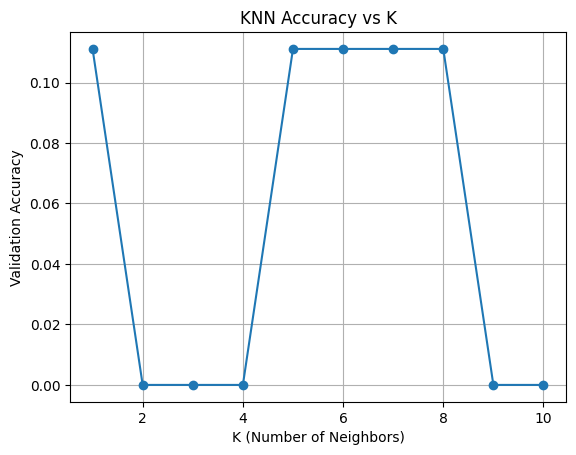

Best K found: 1
Final KNN model trained successfully.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Split into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, random_state=42)

# Try multiple K values to find the best
k_values = range(1, 11)
scores = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    model.fit(X_train, Y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(Y_val, preds)
    scores.append(acc)
    print(f"K={k}: Accuracy={acc:.3f}")

# Plot accuracy vs K
plt.plot(k_values, scores, marker='o')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Validation Accuracy')
plt.title('KNN Accuracy vs K')
plt.grid(True)
plt.show()

# Train final model with best K
best_k = k_values[scores.index(max(scores))]
print("Best K found:", best_k)

final_knn = KNeighborsClassifier(n_neighbors=best_k, metric='cosine')
final_knn.fit(X, Y)

print("Final KNN model trained successfully.")



===== Logistic Regression Performance =====
Exact Match Accuracy: 0.100
Hamming Loss: 0.233
F1 Score (micro): 0.753


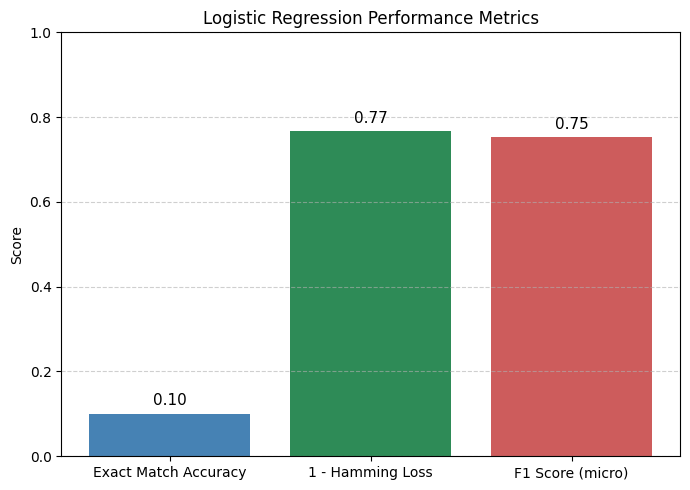

In [19]:
# ================================
# Logistic Regression (Multi-Label)
# ================================
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss, f1_score

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

# Define and train logistic regression model
log_reg = MultiOutputClassifier(LogisticRegression(max_iter=1000))
log_reg.fit(X_train, Y_train)

# Predict on test set
Y_pred = log_reg.predict(X_test)

# Evaluate performance
exact_match = accuracy_score(Y_test, Y_pred)
hamming = hamming_loss(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, average='micro')

print("\n===== Logistic Regression Performance =====")
print(f"Exact Match Accuracy: {exact_match:.3f}")
print(f"Hamming Loss: {hamming:.3f}")
print(f"F1 Score (micro): {f1:.3f}")


import matplotlib.pyplot as plt

# Plot performance metrics
metrics = ['Exact Match Accuracy', '1 - Hamming Loss', 'F1 Score (micro)']
values = [exact_match, 1 - hamming, f1]

plt.figure(figsize=(7, 5))
plt.bar(metrics, values, color=['steelblue', 'seagreen', 'indianred'])
plt.ylim(0, 1)
plt.title("Logistic Regression Performance Metrics")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Display values above bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11)

plt.tight_layout()
plt.show()



In [5]:
import numpy as np
import pandas as pd

# pattern: how many topics to pick per category (5-mark needs 4 topics -> 2 OR pairs)
pattern = {'1_mark_topics': 6, '3_mark_topics': 3, '5_mark_topics': 4}

# list of topic column names in df_wide (Topic_*)
topic_cols = [c for c in df_wide.columns if c.startswith('Topic_')]

predictions_by_category = {}

# For each category, prepare the input (previous exam) and predict probabilities
for category, group in df_wide.groupby('Category'):
    group = group.sort_values('Exam_No').reset_index(drop=True)
    if len(group) < 2:
        # not enough history to predict
        predictions_by_category[category] = []
        continue

    prev_exam = group.iloc[-2]  # exam n (we will predict exam n+1)
    # build X_last row with X_ prefix to match training features
    X_last = prev_exam.filter(like='Topic_').copy()
    X_last.index = X_last.index  # ensure it's Series with Topic_*
    X_last = X_last.to_frame().T  # make DataFrame 1xM
    X_last.columns = ['X_' + col for col in X_last.columns]

    # ensure all training columns exist in the same order
    for col in X.columns:
        if col not in X_last.columns:
            X_last[col] = 0
    X_last = X_last[X.columns]

    # get probability for class 1 for each output (topic)
    # MultiOutputClassifier stores fitted estimators in .estimators_
    probs = {}
    for idx, y_col in enumerate(Y.columns):
        est = log_reg.estimators_[idx]
        # if estimator supports predict_proba
        if hasattr(est, "predict_proba"):
            p = est.predict_proba(X_last)[:, 1][0]  # probability of label=1
        else:
            # fallback to decision_function followed by sigmoid-like map if available
            try:
                df = est.decision_function(X_last)[0]
                p = 1 / (1 + np.exp(-df))
            except Exception:
                p = 0.0
        probs[y_col] = p

    probs_series = pd.Series(probs)

    # determine which topic columns belong to this category historically
    cat_topic_list = [col for col in topic_cols if group[col].sum() >= 0]  # all topic columns valid
    # they are Topic_<name>, but probs_series indexed by 'Y_Topic_<name>'
    cat_y_cols = ['Y_' + t for t in cat_topic_list]

    # Filter only existing Y columns (some topics may not appear for this category; keep intersection)
    cat_y_cols = [c for c in cat_y_cols if c in probs_series.index]

    # If none, skip
    if not cat_y_cols:
        predictions_by_category[category] = []
        continue

    # select top-N by probability among the category's topics
    top_n = pattern.get(category, 3)
    cat_probs = probs_series.loc[cat_y_cols].sort_values(ascending=False)
    selected = cat_probs.head(top_n).index.tolist()  # list of 'Y_Topic_<name>'

    # clean names
    cleaned = [s.replace('Y_Topic_', '') for s in selected]
    predictions_by_category[category] = cleaned

# Format and print final paper
one = predictions_by_category.get('1_mark_topics', [])
three = predictions_by_category.get('3_mark_topics', [])
five = predictions_by_category.get('5_mark_topics', [])

# pad with 'N/A' if fewer predicted
while len(one) < 6:
    one.append('N/A')
while len(three) < 3:
    three.append('N/A')
while len(five) < 4:
    five.append('N/A')

print("\n===== Predicted Exam Paper (by probability, top-N per section) =====")
print(f"1-Mark Questions (6): {', '.join(one[:6])}")
print(f"3-Mark Questions (3): {', '.join(three[:3])}")
print("5-Mark Questions (2, each with OR):")
print(f"Q1: {five[0]} OR {five[1]}")
print(f"Q2: {five[2]} OR {five[3]}")

# Optional: show probabilities (for debugging)
show_probs = False
if show_probs:
    pd.set_option('display.max_rows', None)
    print("\nPredicted probabilities (top 20):")
    for cat in predictions_by_category:
        print(f"\nCategory: {cat}")
        # show sorted probs for that category
        cat_topic_list = [t for t in topic_cols]
        ycols = ['Y_' + t for t in cat_topic_list if 'Y_' + t in probs_series.index]
        print(probs_series.loc[ycols].sort_values(ascending=False).head(20))



===== Predicted Exam Paper (by probability, top-N per section) =====
1-Mark Questions (6): ROC, KNN, Linear, AboutML, FSS, LDA
3-Mark Questions (3): K-Cross Fold, Logistic, BSS
5-Mark Questions (2, each with OR):
Q1: ROC OR Linear
Q2: Logistic OR LDA



===== SVM Performance =====
Exact Match Accuracy: 0.100
Hamming Loss: 0.289
F1 Score (micro): 0.690


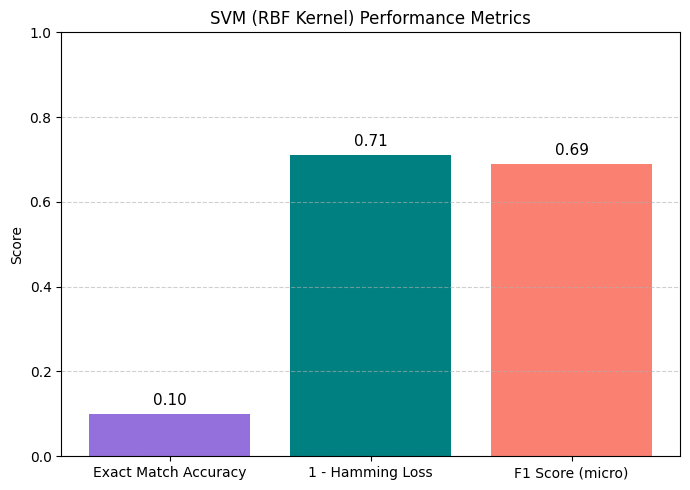

In [20]:
# ================================
# Support Vector Machine (Multi-Label)
# ================================
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss, f1_score

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

# Define and train SVM model (RBF kernel is good general choice)
svm_model = MultiOutputClassifier(SVC(kernel='rbf', probability=True, random_state=42))
svm_model.fit(X_train, Y_train)

# Predict on test set
Y_pred = svm_model.predict(X_test)

# Evaluate performance
exact_match = accuracy_score(Y_test, Y_pred)
hamming = hamming_loss(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, average='micro')

print("\n===== SVM Performance =====")
print(f"Exact Match Accuracy: {exact_match:.3f}")
print(f"Hamming Loss: {hamming:.3f}")
print(f"F1 Score (micro): {f1:.3f}")

import matplotlib.pyplot as plt

# Plot SVM performance metrics
metrics = ['Exact Match Accuracy', '1 - Hamming Loss', 'F1 Score (micro)']
values = [exact_match, 1 - hamming, f1]

plt.figure(figsize=(7, 5))
plt.bar(metrics, values, color=['mediumpurple', 'teal', 'salmon'])
plt.ylim(0, 1)
plt.title("SVM (RBF Kernel) Performance Metrics")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Display metric values above bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=11)

plt.tight_layout()
plt.show()



In [11]:
import numpy as np
import pandas as pd

# Define how many topics to select per section
pattern = {'1_mark_topics': 6, '3_mark_topics': 3, '5_mark_topics': 4}

# List of topic columns from df_wide
topic_cols = [c for c in df_wide.columns if c.startswith('Topic_')]

predictions_by_category = {}

for category, group in df_wide.groupby('Category'):
    group = group.sort_values('Exam_No').reset_index(drop=True)
    if len(group) < 2:
        predictions_by_category[category] = []
        continue

    prev_exam = group.iloc[-2]  # previous exam (n)
    X_last = prev_exam.filter(like='Topic_').copy()
    X_last = X_last.to_frame().T
    X_last.columns = ['X_' + c for c in X_last.columns]

    # Ensure same feature columns as training set
    for col in X.columns:
        if col not in X_last.columns:
            X_last[col] = 0
    X_last = X_last[X.columns]

    # Get probability for each topic
    probs = {}
    for idx, y_col in enumerate(Y.columns):
        est = svm_model.estimators_[idx]
        if hasattr(est, "predict_proba"):
            p = est.predict_proba(X_last)[:, 1][0]
        else:
            # Approximate probability if predict_proba not supported
            try:
                df_val = est.decision_function(X_last)[0]
                p = 1 / (1 + np.exp(-df_val))
            except Exception:
                p = 0.0
        probs[y_col] = p

    probs_series = pd.Series(probs)

    # Get valid Y columns for current category
    cat_y_cols = ['Y_' + c for c in topic_cols if c in group.columns]
    cat_y_cols = [c for c in cat_y_cols if c in probs_series.index]

    if not cat_y_cols:
        predictions_by_category[category] = []
        continue

    # Pick top-N most probable topics for that category
    top_n = pattern.get(category, 3)
    cat_probs = probs_series.loc[cat_y_cols].sort_values(ascending=False)
    selected = cat_probs.head(top_n).index.tolist()

    cleaned = [s.replace('Y_Topic_', '') for s in selected]
    predictions_by_category[category] = cleaned

# Format output
one = predictions_by_category.get('1_mark_topics', [])
three = predictions_by_category.get('3_mark_topics', [])
five = predictions_by_category.get('5_mark_topics', [])

while len(one) < 6:
    one.append('N/A')
while len(three) < 3:
    three.append('N/A')
while len(five) < 4:
    five.append('N/A')

print("\n===== Predicted Exam Paper (SVM-based) =====")
print(f"1-Mark Questions (6): {', '.join(one[:6])}")
print(f"3-Mark Questions (3): {', '.join(three[:3])}")
print("5-Mark Questions (2, each with OR):")
print(f"Q1: {five[0]} OR {five[1]}")
print(f"Q2: {five[2]} OR {five[3]}")



===== Predicted Exam Paper (SVM-based) =====
1-Mark Questions (6): AboutML, ROC, Linear, KNN, Logistic, FSS
3-Mark Questions (3): K-Cross Fold, Logistic, LDA
5-Mark Questions (2, each with OR):
Q1: ROC OR Linear
Q2: Logistic OR LDA



===== Random Forest Classifier =====
Exact Match Accuracy: 0.200
Hamming Loss: 0.256
F1 Score (micro): 0.723


<function matplotlib.pyplot.title(label: 'str', fontdict: 'dict[str, Any] | None' = None, loc: "Literal['left', 'center', 'right'] | None" = None, pad: 'float | None' = None, *, y: 'float | None' = None, **kwargs) -> 'Text'>

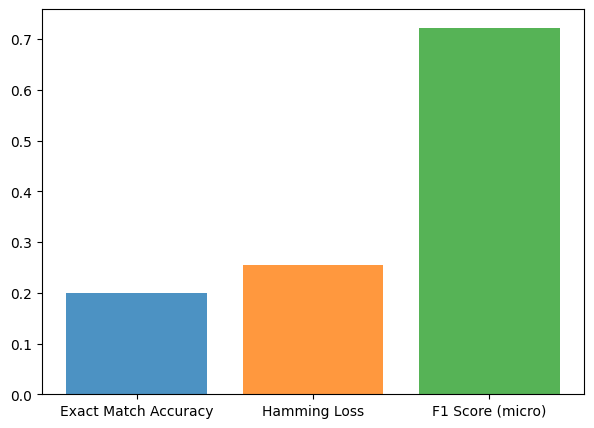

In [21]:
# =======================
# 🔹 RANDOM FOREST CLASSIFIER
# =======================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, hamming_loss

print("\n===== Random Forest Classifier =====")

# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Train model
rf_model.fit(X_train, Y_train)

# Predict on test data
Y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
accuracy_rf = accuracy_score(Y_test, Y_pred_rf)
hamming_rf = hamming_loss(Y_test, Y_pred_rf)
f1_rf = f1_score(Y_test, Y_pred_rf, average='micro')

print(f"Exact Match Accuracy: {accuracy_rf:.3f}")
print(f"Hamming Loss: {hamming_rf:.3f}")
print(f"F1 Score (micro): {f1_rf:.3f}")

# ================================
# 📊 Random Forest Performance Visualization
# ================================
import matplotlib.pyplot as plt
import numpy as np

# Metrics for plotting
metrics = ['Exact Match Accuracy', 'Hamming Loss', 'F1 Score (micro)']
values = [accuracy_rf, hamming_rf, f1_rf]

plt.figure(figsize=(7, 5))
bars = plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
plt.title



In [18]:
# ===================================
# 🔹 Predict Next Exam using Random Forest (Stable & Clean)
# ===================================
import numpy as np
import pandas as pd

pattern = {'1_mark_topics': 6, '3_mark_topics': 3, '5_mark_topics': 4}
topic_cols = [c for c in df_wide.columns if c.startswith('Topic_')]

predictions_by_category_rf = {}

for category, group in df_wide.groupby('Category'):
    group = group.sort_values('Exam_No').reset_index(drop=True)
    if len(group) < 2:
        predictions_by_category_rf[category] = []
        continue

    # Previous exam (X_last)
    prev_exam = group.iloc[-2]
    X_last = prev_exam.filter(like='Topic_').to_frame().T
    X_last.columns = ['X_' + col for col in X_last.columns]

    # Ensure all training features exist
    for col in X.columns:
        if col not in X_last.columns:
            X_last[col] = 0
    X_last = X_last[X.columns]
    X_last_np = X_last.to_numpy()  # Fix: use numpy array to avoid feature name warning

    # Predict topic probabilities for next exam
    probs_rf = {}
    for idx, y_col in enumerate(Y.columns):
        est = rf_model.estimators_[idx]
        try:
            if hasattr(est, "predict_proba"):
                p = est.predict_proba(X_last_np)[0, 1]
            else:
                p = 0.5  # neutral confidence if no probas
        except Exception:
            p = 0.5
        probs_rf[y_col] = p

    probs_series = pd.Series(probs_rf)

    # Filter topics that belong to this category
    cat_prefix = category.split('_')[0]
    cat_topic_list = [t for t in topic_cols if cat_prefix in t]
    cat_y_cols = ['Y_' + t for t in cat_topic_list if 'Y_' + t in probs_series.index]

    # If no topics matched, skip
    if not cat_y_cols:
        predictions_by_category_rf[category] = []
        continue

    # Pick top-N topics by probability
    top_n = pattern.get(category, 3)
    cat_probs = probs_series.loc[cat_y_cols].sort_values(ascending=False)
    selected = cat_probs.head(top_n).index.tolist()
    cleaned = [s.replace('Y_Topic_', '') for s in selected]
    predictions_by_category_rf[category] = cleaned

# 🧾 Print predicted paper
one = predictions_by_category_rf.get('1_mark_topics', [])
three = predictions_by_category_rf.get('3_mark_topics', [])
five = predictions_by_category_rf.get('5_mark_topics', [])

while len(one) < 6: one.append('N/A')
while len(three) < 3: three.append('N/A')
while len(five) < 4: five.append('N/A')

print("\n===== Predicted Exam Paper (Random Forest - Final Clean) =====")
print(f"1-Mark Questions (6): {', '.join(one[:6])}")
print(f"3-Mark Questions (3): {', '.join(three[:3])}")
print("5-Mark Questions (2, each with OR):")
print(f"Q1: {five[0]} OR {five[1]}")
print(f"Q2: {five[2]} OR {five[3]}")



===== Predicted Exam Paper (Random Forest - Final Clean) =====
1-Mark Questions (6): N/A, N/A, N/A, N/A, N/A, N/A
3-Mark Questions (3): N/A, N/A, N/A
5-Mark Questions (2, each with OR):
Q1: N/A OR N/A
Q2: N/A OR N/A
